подгружаем библиотеки

In [ ]:
import os
import sys
import time
import datetime
import random
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from dataclasses import dataclass
import requests
import cv2
import scipy
from torchvision.utils import make_grid, save_image
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms as tr
from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm.auto import tqdm, trange
from torch.optim.lr_scheduler import ExponentialLR
from dataclasses import dataclass
import requests
import cv2
import scipy

dataset_folder = "/home/itmo/Projects/sp_tec/contest_ysda/"
dataset_name = "apple2orange"
target_folder = os.path.join(dataset_folder, dataset_name)

Выбираем датасет с апельсинами и яблоками

In [ ]:
class ImageDatasetNoLabel(Dataset):
    def __init__(self, target_folder, transform=None):
        super(ImageDatasetNoLabel, self).__init__()
        self.target_folder = target_folder
        self.transform = transform
        self.image_paths = sorted([os.path.join(self.target_folder, img) for img in os.listdir(self.target_folder)])

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.image_paths)

@dataclass
class DatasetsClass:
    train_a: ImageDatasetNoLabel
    train_b: ImageDatasetNoLabel
    test_a: ImageDatasetNoLabel
    test_b: ImageDatasetNoLabel


ds = DatasetsClass(
    train_a=ImageDatasetNoLabel(os.path.join(target_folder, "trainA")),
    train_b=ImageDatasetNoLabel(os.path.join(target_folder, "trainB")),
    test_a=ImageDatasetNoLabel(os.path.join(target_folder, "testA")),
    test_b=ImageDatasetNoLabel(os.path.join(target_folder, "testB")),
)

Функция для получения поканальных статистик (среднее и отклонение) по датасету

In [ ]:
def get_channel_statistics(dataset):
    channel_mean = np.zeros((3))
    channel_std = np.zeros((3))
    for idx in range(len(dataset)):
        img_path = dataset.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.array(img) / 255.
        channel_mean += img.mean(axis=(0, 1))
        channel_std += img.std(axis=(0, 1))
    channel_mean /= len(dataset)
    channel_std /= len(dataset)
    return channel_mean, channel_std

channel_mean_a, channel_std_a = get_channel_statistics(ds.train_a)
channel_mean_b, channel_std_b = get_channel_statistics(ds.train_b)


Вывод статистик для яблок и апельсинов

In [ ]:
print(channel_mean_a, channel_std_a)
print(channel_mean_b, channel_std_b)

[0.5921445  0.42005586 0.36589783] [0.23393021 0.27317463 0.25901916]
[0.65257136 0.48343966 0.29913012] [0.21546932 0.21178623 0.22519237]


Функция для трансформов

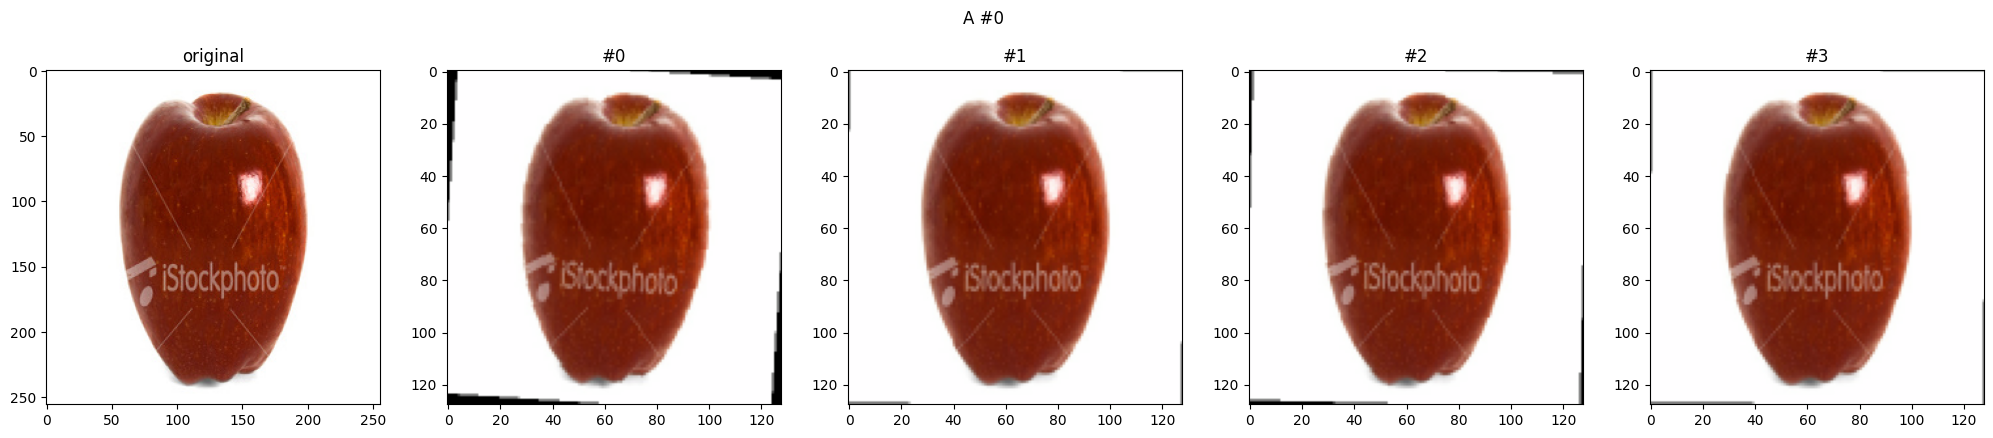

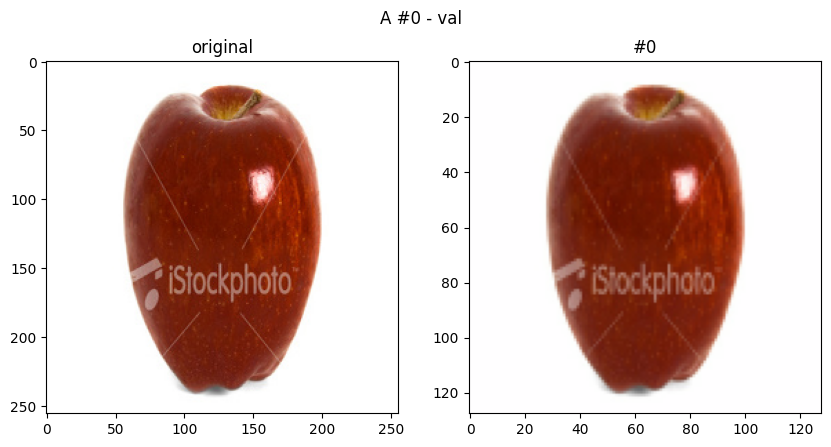

In [ ]:
def get_transforms(mean, std):
    train_transform = tr.Compose([
        tr.ToPILImage(),
        tr.RandomRotation(10),
        tr.ToTensor(),
        tr.Normalize(mean=mean, std=std),
        tr.Resize((128,128))
    ])

    test_transform = tr.Compose([
        tr.ToPILImage(),
        tr.ToTensor(),
        tr.Normalize(mean=mean, std=std),
        tr.Resize((128,128))
    ])

    def de_normalize(img):
        img = img.cpu()
        img_np = img.numpy()
        de_normalized_img = (img_np * std[:, None, None]) + mean[:, None, None]
        de_normalized_img = np.clip(de_normalized_img, 0, 1)
        de_normalized_img = np.moveaxis(de_normalized_img, 0, -1)
        return de_normalized_img

    return train_transform, test_transform, de_normalize



train_transform_a, val_transform_a, de_normalize_a = get_transforms(channel_mean_a, channel_std_a)
train_transform_b, val_transform_b, de_normalize_b = get_transforms(channel_mean_b, channel_std_b)

def show_examples(dataset, transform, de_norm, num_per_image=3, image_index=0, title=""):
    fig, ax = plt.subplots(1, 1 + num_per_image, figsize=(5 * (1 + num_per_image), 5))

    image = dataset[image_index]

    plt.suptitle(title, y=0.95)

    plt.subplot(1, 1 + num_per_image, 1)
    plt.imshow(image)
    plt.title("original")

    for i in range(num_per_image):
        plt.subplot(1, 1 + num_per_image, i + 2)
        plt.title(f"#{i}")
        plt.imshow(de_norm(transform(image)))
    plt.show()

show_examples(ds.train_a, train_transform_a, de_normalize_a, num_per_image=4, image_index=0, title="A #0")
show_examples(ds.train_a, val_transform_a, de_normalize_a, num_per_image=1, image_index=0, title="A #0 - val")

организуем наши датасеты

In [ ]:
ds = DatasetsClass(
    train_a=ImageDatasetNoLabel(
        os.path.join(target_folder, "trainA"),
        transform=train_transform_a,
    ),
    train_b=ImageDatasetNoLabel(
        os.path.join(target_folder, "trainB"),
        transform=val_transform_b,
    ),
    test_a=ImageDatasetNoLabel(
        os.path.join(target_folder, "testA"),
        transform=val_transform_a,
    ),
    test_b=ImageDatasetNoLabel(
        os.path.join(target_folder, "testB"),
        transform=val_transform_b,
    ),
)

In [ ]:
@dataclass
class DataLoadersClass:
    train_a: DataLoader
    train_b: DataLoader
    test_a: DataLoader
    test_b: DataLoader

batch_size = 50

dataloaders = DataLoadersClass(
    train_a=DataLoader(
        dataset=ds.train_a,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    ),
    train_b=DataLoader(
        dataset=ds.train_b,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    ),
    test_a=DataLoader(
        dataset=ds.test_a,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    ),
    test_b=DataLoader(
        dataset=ds.test_b,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    ),
)

Перейдем к модели CycleGAN

ResidualBlock - это блок, который состоит из двух сверточных слоев с активацией ReLU между ними. Он также включает в себя операцию отражения (reflection padding) для сохранения размерности изображения. Этот блок используется для улучшения обучения глубоких нейронных сетей, позволяя им обучаться на более сложных функциях, добавляя "остаточные" связи между слоями.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

Generator - это часть GAN, которая генерирует изображения. Он начинается с сверточного слоя, который увеличивает размерность входных данных. Затем следует последовательность сверточных и транспонирующих сверточных слоев, которые уменьшают размерность изображения, а затем увеличивают его обратно до исходного размера. Между этими слоями расположены блоки ResidualBlock, которые помогают улучшить обучение и обобщать функции.

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


Discriminator - это часть GAN, которая пытается отличить сгенерированные изображения от реальных. Он состоит из последовательности сверточных слоев с активацией LeakyReLU, которые уменьшают размерность изображения, и сверточного слоя в конце, который классифицирует изображение как реальное или сгенерированное.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

Соберем класс CycleGAN. Это будет нашей реализацией модели CycleGAN, которая используется для преобразования изображений из одного домена в другой и обратно. CycleGAN отличается от традиционных GAN тем, что он обучается на парах изображений, где каждое изображение из пары является "реальным" изображением из одного домена, а другое изображение является "реальным" изображением из другого домена. Цель CycleGAN - обучить генераторы таким образом, чтобы они могли не только генерировать изображения из одного домена в другой, но и воспроизводить исходные изображения из домена B, когда они преобразуются в домен A, и наоборот.

In [ ]:
class CycleGAN(nn.Module):
    def __init__(self, device):
        super(CycleGAN, self).__init__()
        self.device = device
        img_channels = 3
        self.G_AB = Generator(img_channels, img_channels).to(device)
        self.G_BA = Generator(img_channels, img_channels).to(device)
        self.D_A = Discriminator(img_channels).to(device)
        self.D_B = Discriminator(img_channels).to(device)

    def forward(self, real_A, real_B):
        fake_B = self.G_AB(real_A)
        cycled_A = self.G_BA(fake_B)
        fake_A = self.G_BA(real_B)
        cycled_B = self.G_AB(fake_A)

        return fake_A, fake_B, cycled_A, cycled_B

Перейдем к LOSS

In [ ]:
class CycleConsistencyLoss(nn.Module):

    def __init__(self):
        super(CycleConsistencyLoss, self).__init__()

    def forward(self, x, x_rec):
        return torch.mean(torch.abs(x - x_rec))

In [ ]:
class AdversarialLossCE(nn.Module):
    def __init__(self):
        super(AdversarialLossCE, self).__init__()

    def forward(self, real_pred, fake_pred=None):
        if fake_pred is not None:
            d_real = torch.mean(torch.log(real_pred))
            d_fake = torch.mean(torch.log(1 - fake_pred))
            d_loss = - (d_real + d_fake)*0.5
            return dis_loss
        else:
            g_loss = -torch.mean(torch.log(1 - real_pred))
            return g_loss

In [ ]:
class AdversarialLossMSE(nn.Module):

    def __init__(self):
        super(AdversarialLossMSE, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, real_pred, fake_pred=None):

        if fake_pred is not None:
            d_real = self.mse_loss(real_pred, torch.ones_like(real_pred))
            d_fake = self.mse_loss(fake_pred, torch.zeros_like(fake_pred))
            d_loss = (d_real + d_fake)*0.5
            return d_loss
        else:
            g_loss = self.mse_loss(real_pred, torch.ones_like(real_pred))
            return g_loss

In [ ]:
class FullDiscriminatorLoss(nn.Module):
    def __init__(self, is_mse=True):
        super(FullDiscriminatorLoss, self).__init__()
        if is_mse:
            self.adversarial_loss_func = AdversarialLossMSE()
        else:
            self.adversarial_loss_func = AdversarialLossCE()

    def forward(self, real_pred, fake_pred=None):
        loss = self.adversarial_loss_func.forward(real_pred, fake_pred)
        return loss

In [ ]:
class FullGeneratorLoss(nn.Module):

    def __init__(self, lambda_value=10., is_mse=True):
        super(FullGeneratorLoss, self).__init__()
        if is_mse:
            self.adversarial_loss_func = AdversarialLossMSE()
        else:
            self.adversarial_loss_func = AdversarialLossCE()
        self.cycle_consistency_loss_func = CycleConsistencyLoss()
        self.lambda_value = lambda_value

    def forward(self, real_pred, fake_pred, rec):
        loss_GAN = self.adversarial_loss_func.forward(real_pred)
        loss_cyc = self.cycle_consistency_loss_func.forward(real_pred, rec)
        return loss_GAN + self.lambda_value * loss_cyc

Перейдем к подготовке обучения

In [ ]:
def train_discriminators(model, opt_d, loader_a, loader_b, criterion_d):
    model.train()
    losses_tr = []

    iter_a = iter(loader_a)
    iter_b = iter(loader_b)
    batches_per_epoch = min(len(iter_a), len(iter_b))

    for _ in trange(batches_per_epoch):
        imgs_a = next(iter_a).to(device)
        imgs_b = next(iter_b).to(device)

        opt_d.zero_grad()

        fake_A = model.G_BA(imgs_b).detach()
        fake_B = model.G_AB(imgs_a).detach()

        real_pred_A = model.D_A(imgs_a)
        fake_pred_A = model.D_A(fake_A)
        real_pred_B = model.D_B(imgs_b)
        fake_pred_B = model.D_B(fake_B)

        loss_A = criterion_d(real_pred_A, fake_pred_A)
        loss_B = criterion_d(real_pred_B, fake_pred_B)
        loss = (loss_A + loss_B)*0.5

        loss.backward()
        opt_d.step()
        losses_tr.append(loss.item())

    return model, opt_d, np.mean(losses_tr)

In [ ]:
def train_generators(model, opt_g, loader_a, loader_b, criterion_g):
    model.train()
    total_loss = 0.0
    iter_a = iter(loader_a)
    iter_b = iter(loader_b)
    batches_per_epoch = min(len(loader_a), len(loader_b))

    for i in trange(batches_per_epoch):
        imgs_a = next(iter_a).to(model.device)
        imgs_b = next(iter_b).to(model.device)

        opt_g.zero_grad()

        fake_A = model.G_BA(imgs_b)
        fake_B = model.G_AB(imgs_a)
        rec_A = model.G_BA(fake_B)
        rec_B = model.G_AB(fake_A)

        loss_A = criterion_g(imgs_a, fake_A, rec_A)
        loss_B = criterion_g(imgs_b, fake_B, rec_B)

        loss = (loss_A + loss_B)*0.5
        loss.backward()
        opt_g.step()
        total_loss += loss.item()

    average_loss = total_loss / batches_per_epoch
    return model, opt_g, average_loss

Шаг валидации

In [ ]:
from collections import defaultdict

def val(model, loader_a, loader_b, criterion_d, criterion_g):
    model.eval()
    val_data = defaultdict(list)

    with torch.no_grad():
        iter_a = iter(loader_a)
        iter_b = iter(loader_b)
        batches_per_epoch = min(len(loader_a), len(loader_b))

        for _ in trange(batches_per_epoch):
            imgs_a = next(iter_a).to(model.device)
            imgs_b = next(iter_b).to(model.device)

            fake_A = model.G_BA(imgs_b)
            fake_B = model.G_AB(imgs_a)

            rec_A = model.G_BA(fake_B)
            rec_B = model.G_AB(fake_A)

            real_pred_A = model.D_A(imgs_a)
            fake_pred_A = model.D_A(fake_A)
            real_pred_B = model.D_B(imgs_b)
            fake_pred_B = model.D_B(fake_B)

            loss_d_A = criterion_d(real_pred_A, fake_pred_A)
            loss_d_B = criterion_d(real_pred_B, fake_pred_B)
            loss_g_A = criterion_g(imgs_a, fake_A, rec_A)
            loss_g_B = criterion_g(imgs_b, fake_B, rec_B)

            loss_d = (loss_d_A + loss_d_B)*0.5
            loss_g = (loss_g_A + loss_g_B)*0.5

            val_data["loss D"].append(loss_d.item())
            val_data["loss G"].append(loss_g.item())

            real_pred_A = torch.sigmoid(real_pred_A).cpu().detach().numpy()
            real_pred_B = torch.sigmoid(real_pred_B).cpu().detach().numpy()
            fake_pred_A = torch.sigmoid(fake_pred_A).cpu().detach().numpy()
            fake_pred_B = torch.sigmoid(fake_pred_B).cpu().detach().numpy()

            val_data["real pred A"].extend(real_pred_A.tolist())
            val_data["real pred B"].extend(real_pred_B.tolist())
            val_data["fake pred A"].extend(fake_pred_A.tolist())
            val_data["fake pred B"].extend(fake_pred_B.tolist())

        val_data["loss D"] = np.mean(val_data["loss D"])
        val_data["loss G"] = np.mean(val_data["loss G"])

    return val_data

In [ ]:
def draw_imgs(model, num_images, loader_a, loader_b, de_norm_a, de_norm_b):
    model.eval()
    with torch.no_grad():
        imgs_a = next(iter(loader_a))[:num_images].to(device)
        imgs_b = next(iter(loader_b))[:num_images].to(device)

        fake_a = model.G_BA(imgs_b)
        fake_b = model.G_AB(imgs_a)
        rec_a = model.G_BA(fake_b)
        rec_b = model.G_AB(fake_a)

        fig, ax = plt.subplots(num_images, 3, figsize=(25, 15))
        plt.suptitle("Images from A", y=0.92)

        max_index = min(imgs_a.size(0), imgs_b.size(0), num_images)

        for ind in range(max_index):
            plt.subplot(num_images, 3, ind * 3 + 1)
            plt.title("Original from A")
            plt.imshow(de_norm_a(imgs_a[ind]))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 2)
            plt.title("Translated to B")
            plt.imshow(de_norm_b(fake_b[ind]))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 3)
            plt.title("Reconstructed A")
            plt.imshow(de_norm_a(rec_a[ind]))
            plt.xticks([])
            plt.yticks([])

        fig, ax = plt.subplots(num_images, 3, figsize=(25, 15))
        plt.suptitle("Images from B", y=0.92)

        for ind in range(max_index):
            plt.subplot(num_images, 3, ind * 3 + 1)
            plt.title("Original from B")
            plt.imshow(de_norm_b(imgs_b[ind]))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 2)
            plt.title("Translated to A")
            plt.imshow(de_norm_a(fake_a[ind]))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 3)
            plt.title("Reconstructed B")
            plt.imshow(de_norm_b(rec_b[ind]))
            plt.xticks([])
            plt.yticks([])

        plt.show()

In [ ]:
from IPython.display import clear_output
import warnings

def get_model_name(chkp_folder, model_name=None):
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        if "#" not in model_name:
            model_name += "#0"
    changed = False
    while os.path.exists(os.path.join(chkp_folder, model_name + '.pt')):
        model_name, ind = model_name.split("#")
        model_name += f"#{int(ind) + 1}"
        changed=True
    if changed:
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    return model_name


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(
    model,
    optimizer_g,
    g_iters_per_epoch,
    optimizer_d,
    d_iters_per_epoch,
    train_loader_a,
    train_loader_b,
    val_loader_a,
    val_loader_b,
    criterion_d,
    criterion_g,
    de_norm_a,
    de_norm_b,
    scheduler_d=None,
    scheduler_g=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    model_name=None,
    chkp_folder="./chkps",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
):
    model_name = get_model_name(chkp_folder, model_name)

    if plots is None:
        plots = {
            'train G': [],
            'train D': [],
            'val D': [],
            'val G': [],
            "lr G": [],
            "lr D": [],
            "hist real A": [],
            "hist gen A": [],
            "hist real B": [],
            "hist gen B": [],
        }

    for epoch in np.arange(1, epochs+1) + starting_epoch:
        print(f'#{epoch}/{epochs}:')

        plots['lr G'].append(get_lr(optimizer_g))
        plots['lr D'].append(get_lr(optimizer_d))

        print(f"train discriminators ({d_iters_per_epoch} times)")
        loss_d = []
        for _ in range(d_iters_per_epoch):
            model, optimizer_d, loss = train_discriminators(model, optimizer_d, train_loader_a, train_loader_b, criterion_d)
            loss_d.append(loss)
        plots['train D'].extend(loss_d)

        print(f"train generators ({g_iters_per_epoch} times)")
        loss_g = []
        for _ in range(g_iters_per_epoch):
            model, optimizer_g, loss = train_generators(model, optimizer_g, train_loader_a, train_loader_b, criterion_g)
            loss_g.append(loss)
        plots['train G'].extend(loss_g)

        if not (epoch % val_every):
            print("validate")
            val_data = val(model, val_loader_a, val_loader_b, criterion_d, criterion_g)
            plots['val D'].append(val_data["loss D"])
            plots['val G'].append(val_data["loss G"])
            plots['hist real A'].append(val_data["real pred A"])
            plots['hist gen A'].append(val_data["fake pred A"])
            plots['hist real B'].append(val_data["real pred B"])
            plots['hist gen B'].append(val_data["fake pred B"])

            if not os.path.exists(chkp_folder):
                os.makedirs(chkp_folder)
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_d_state_dict': optimizer_d.state_dict(),
                    'optimizer_g_state_dict': optimizer_g.state_dict(),
                    'scheduler_d_state_dict': scheduler_d.state_dict(),
                    'scheduler_g_state_dict': scheduler_g.state_dict(),
                    'plots': plots,
                },
                os.path.join(chkp_folder, model_name + '.pt'),
            )

            if scheduler_d:
                try:
                    scheduler_d.step()
                except:
                    scheduler_d.step(loss_d)
            if scheduler_g:
                try:
                    scheduler_g.step()
                except:
                    scheduler_g.step(loss_g)

        if not (epoch % draw_every):
            clear_output(True)

            hh = 2
            ww = 2
            plt_ind = 1
            fig, ax = plt.subplots(hh, ww, figsize=(25, 12))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(hh, ww, plt_ind)
            plt.title('discriminators losses')
            d_plot_step = 1. / d_iters_per_epoch
            plt.plot(np.arange(d_plot_step, epoch + d_plot_step, d_plot_step), plots['train D'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val D'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title('generators losses')
            g_plot_step = 1. / g_iters_per_epoch
            plt.plot(np.arange(g_plot_step, epoch + g_plot_step, g_plot_step), plots['train G'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val G'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1


            real_A_data_flat = np.array(plots["hist real A"][-1]).flatten()
            gen_A_data_flat = np.array(plots["hist gen A"][-1]).flatten()
            real_B_data_flat = np.array(plots["hist real B"][-1]).flatten()
            gen_B_data_flat = np.array(plots["hist gen B"][-1]).flatten()

            plt.subplot(hh, ww, plt_ind)
            plt.title("Discriminator A predictions")
            plt.hist(real_A_data_flat, bins=50, density=True, label="real", color="green", alpha=0.7)
            plt.hist(gen_A_data_flat, bins=50, density=True, label="generated", color="red", alpha=0.7)
            plt.xlim((-0.05, 1.05))
            plt.xticks(ticks=np.arange(0, 1.05, 0.1))
            plt.legend()
            plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title("Discriminator B predictions")
            plt.hist(real_B_data_flat, bins=50, density=True, label="real", color="green", alpha=0.7)
            plt.hist(gen_B_data_flat, bins=50, density=True, label="generated", color="red", alpha=0.7)
            plt.xlim((-0.05, 1.05))
            plt.xticks(ticks=np.arange(0, 1.05, 0.1))
            plt.legend()
            plt_ind += 1

            plt.show()

            draw_imgs(model, images_per_validation, val_loader_a, val_loader_b, de_norm_a, de_norm_b)


        if min_lr and get_lr(optimizer_d) <= min_lr:
            print(f'Learning process ended with early stop for discriminator after epoch {epoch}')
            break

        if min_lr and get_lr(optimizer_g) <= min_lr:
            print(f'Learning process ended with early stop for generator after epoch {epoch}')
            break

    return model, optimizer_d, optimizer_g, plots

In [ ]:
from collections import defaultdict
from termcolor import colored


def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))


def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda : [0, 0])
    for name, param in model.named_parameters():
        num_params = param.numel()
        if verbose_all or (verbose_only_learnable and param.requires_grad):
            print(
                colored(
                    '{: <65} ~  {: <9} params ~ grad: {}'.format(
                        name,
                        beautiful_int(num_params),
                        param.requires_grad,
                    ),
                    {True: "green", False: "red"}[param.requires_grad],
                )
            )
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )

    for sm, v in submodules.items():
        print(
            f"\n . {sm}:\n .   - {beautiful_int(submodules[sm][0])} params\n .   - {beautiful_int(submodules[sm][1])} learnable params"
        )
    return sum_params, sum_learnable_params

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-3, betas=(0.5, 0.999), device=device):
    model = model_class(**model_params)
    model = model.to(device)

    optimizer_d = torch.optim.Adam(
        model.parameters(),
        lr,
        betas,
    )
    optimizer_g = torch.optim.Adam(
        model.parameters(),
        lr,
        betas,
    )
    return model, optimizer_d, optimizer_g

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

results = []

model, optimizer_d, optimizer_g = create_model_and_optimizer(
    model_class = CycleGAN,
    model_params = { 'device': device},
    lr = 1e-3,
    device = device,
)


scheduler_d = ExponentialLR(optimizer_d, gamma=0.9)
scheduler_g = ExponentialLR(optimizer_g, gamma=0.9)

criterion_d = FullDiscriminatorLoss()
criterion_g = FullGeneratorLoss()

sum_params, sum_learnable_params = model_num_params(model)

G_AB.model.1.weight                                               ~  9.408     params ~ grad: True
G_AB.model.1.bias                                                 ~  64        params ~ grad: True
G_AB.model.4.weight                                               ~  73.728    params ~ grad: True
G_AB.model.4.bias                                                 ~  128       params ~ grad: True
G_AB.model.7.weight                                               ~  294.912   params ~ grad: True
G_AB.model.7.bias                                                 ~  256       params ~ grad: True
G_AB.model.10.conv_block.1.weight                                 ~  589.824   params ~ grad: True
G_AB.model.10.conv_block.1.bias                                   ~  256       params ~ grad: True
G_AB.model.10.conv_block.5.weight                                 ~  589.824   params ~ grad: True
G_AB.model.10.conv_block.5.bias                                   ~  256       params ~ grad: True
G_AB.model

In [ ]:
model

CycleGAN(
  (G_AB): Generator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): ReLU(inplace=True)
      (10): ResidualBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (3): ReLU(inplace=True

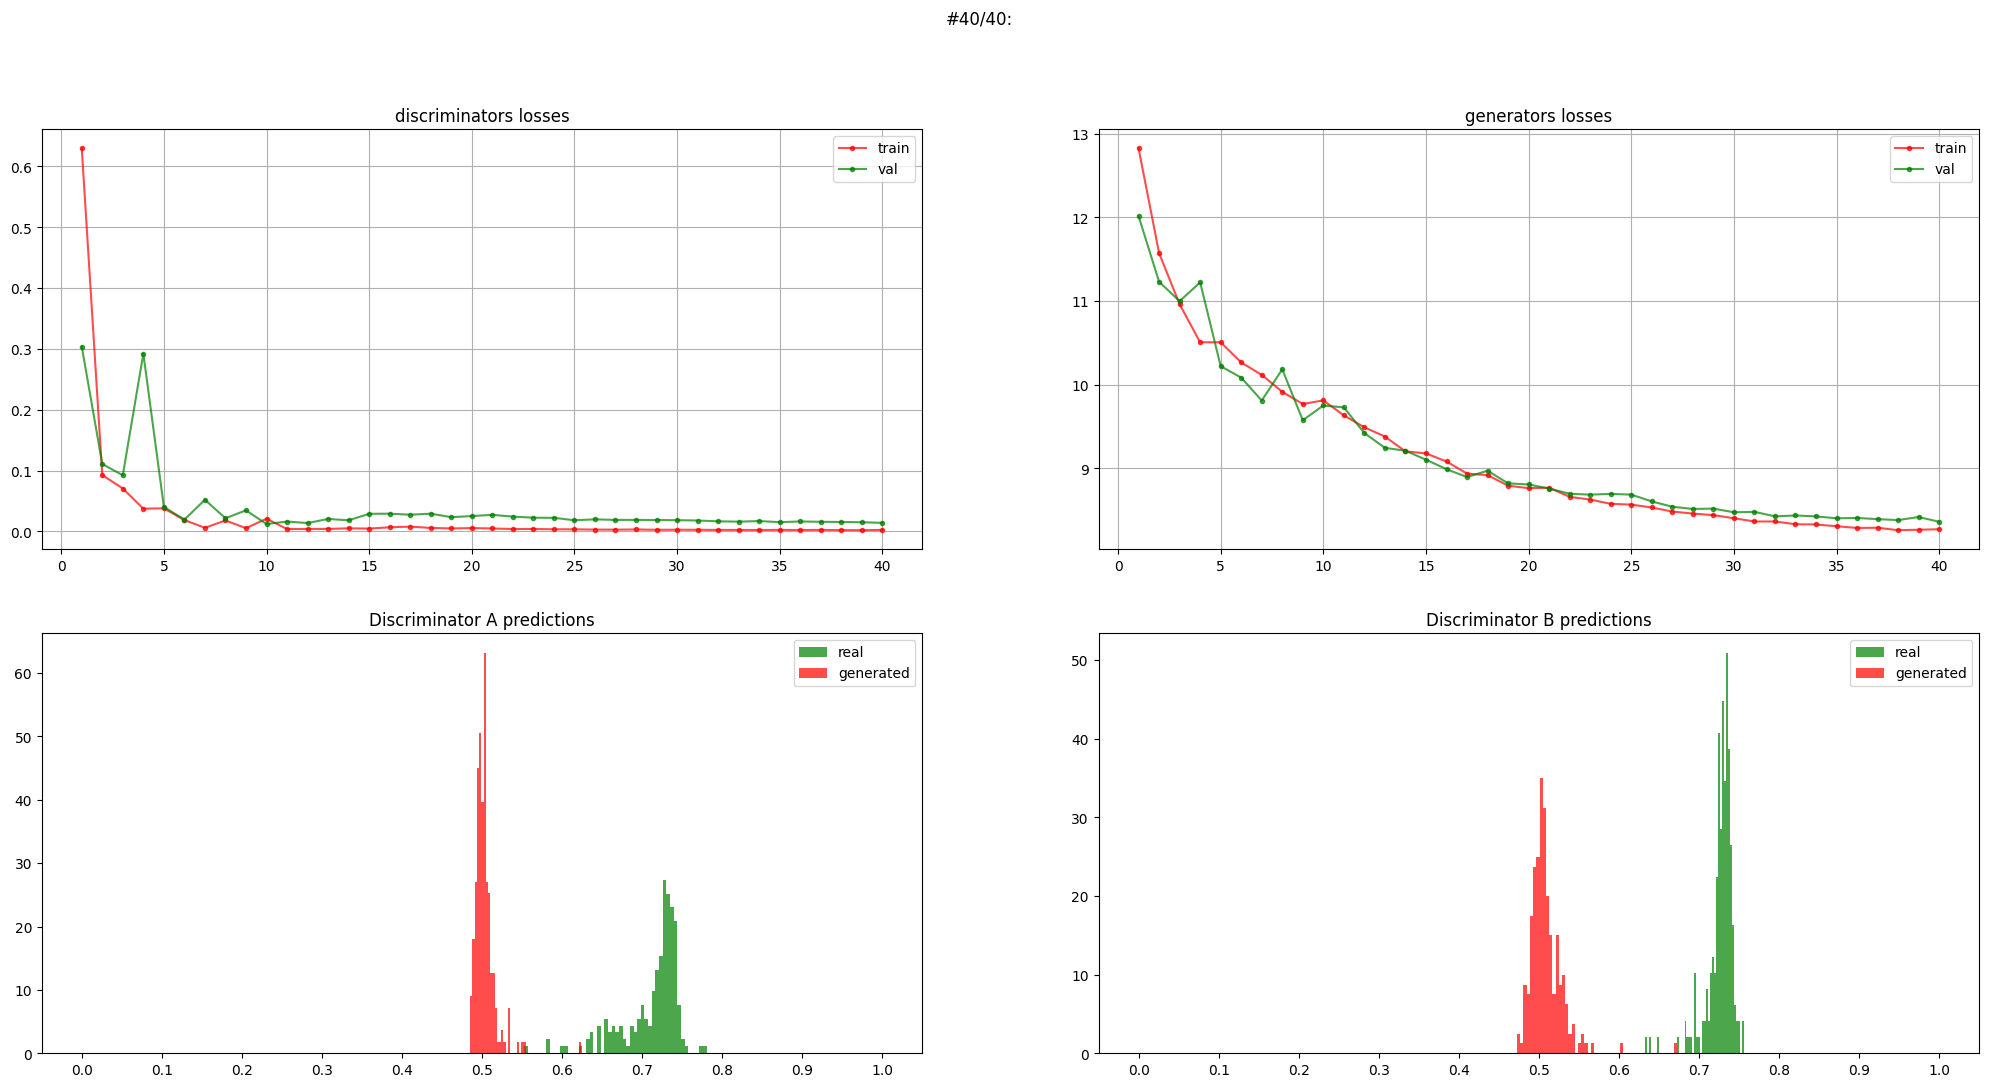

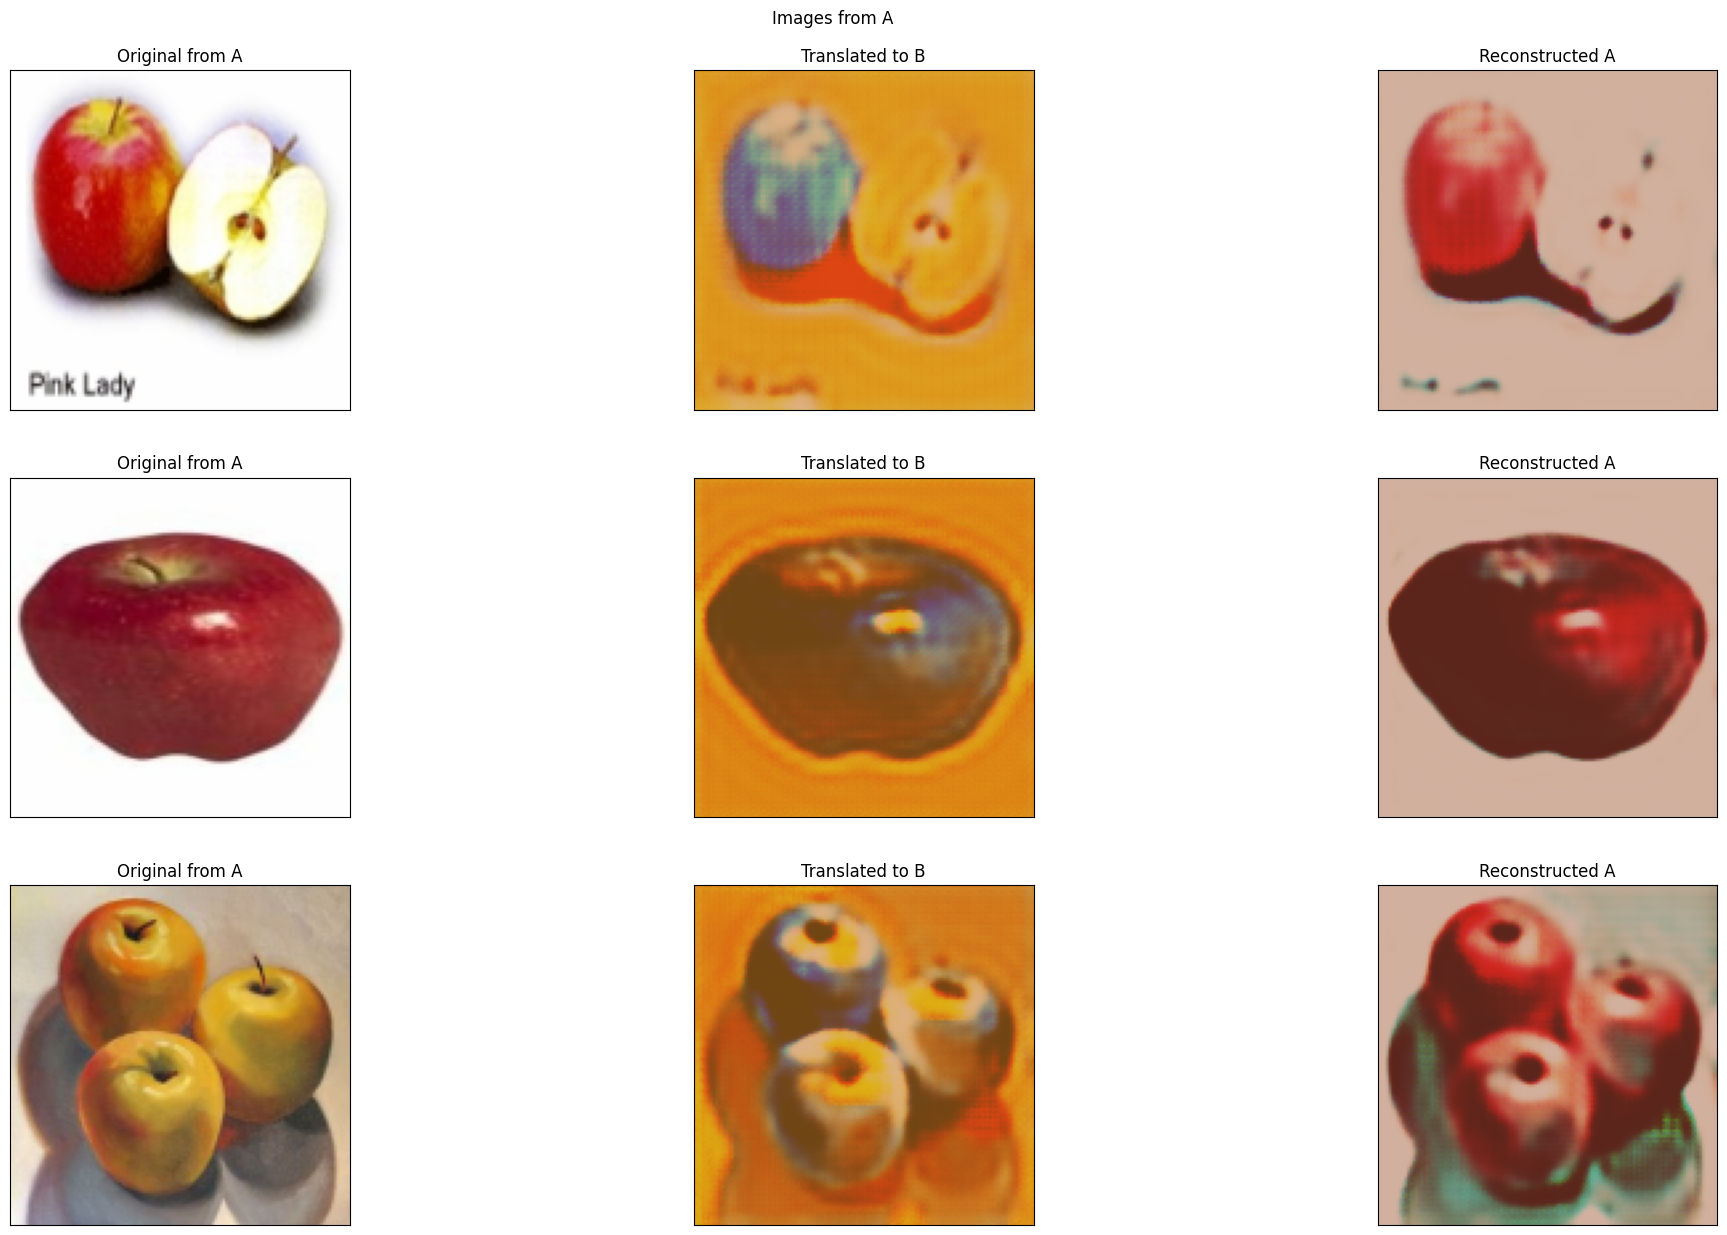

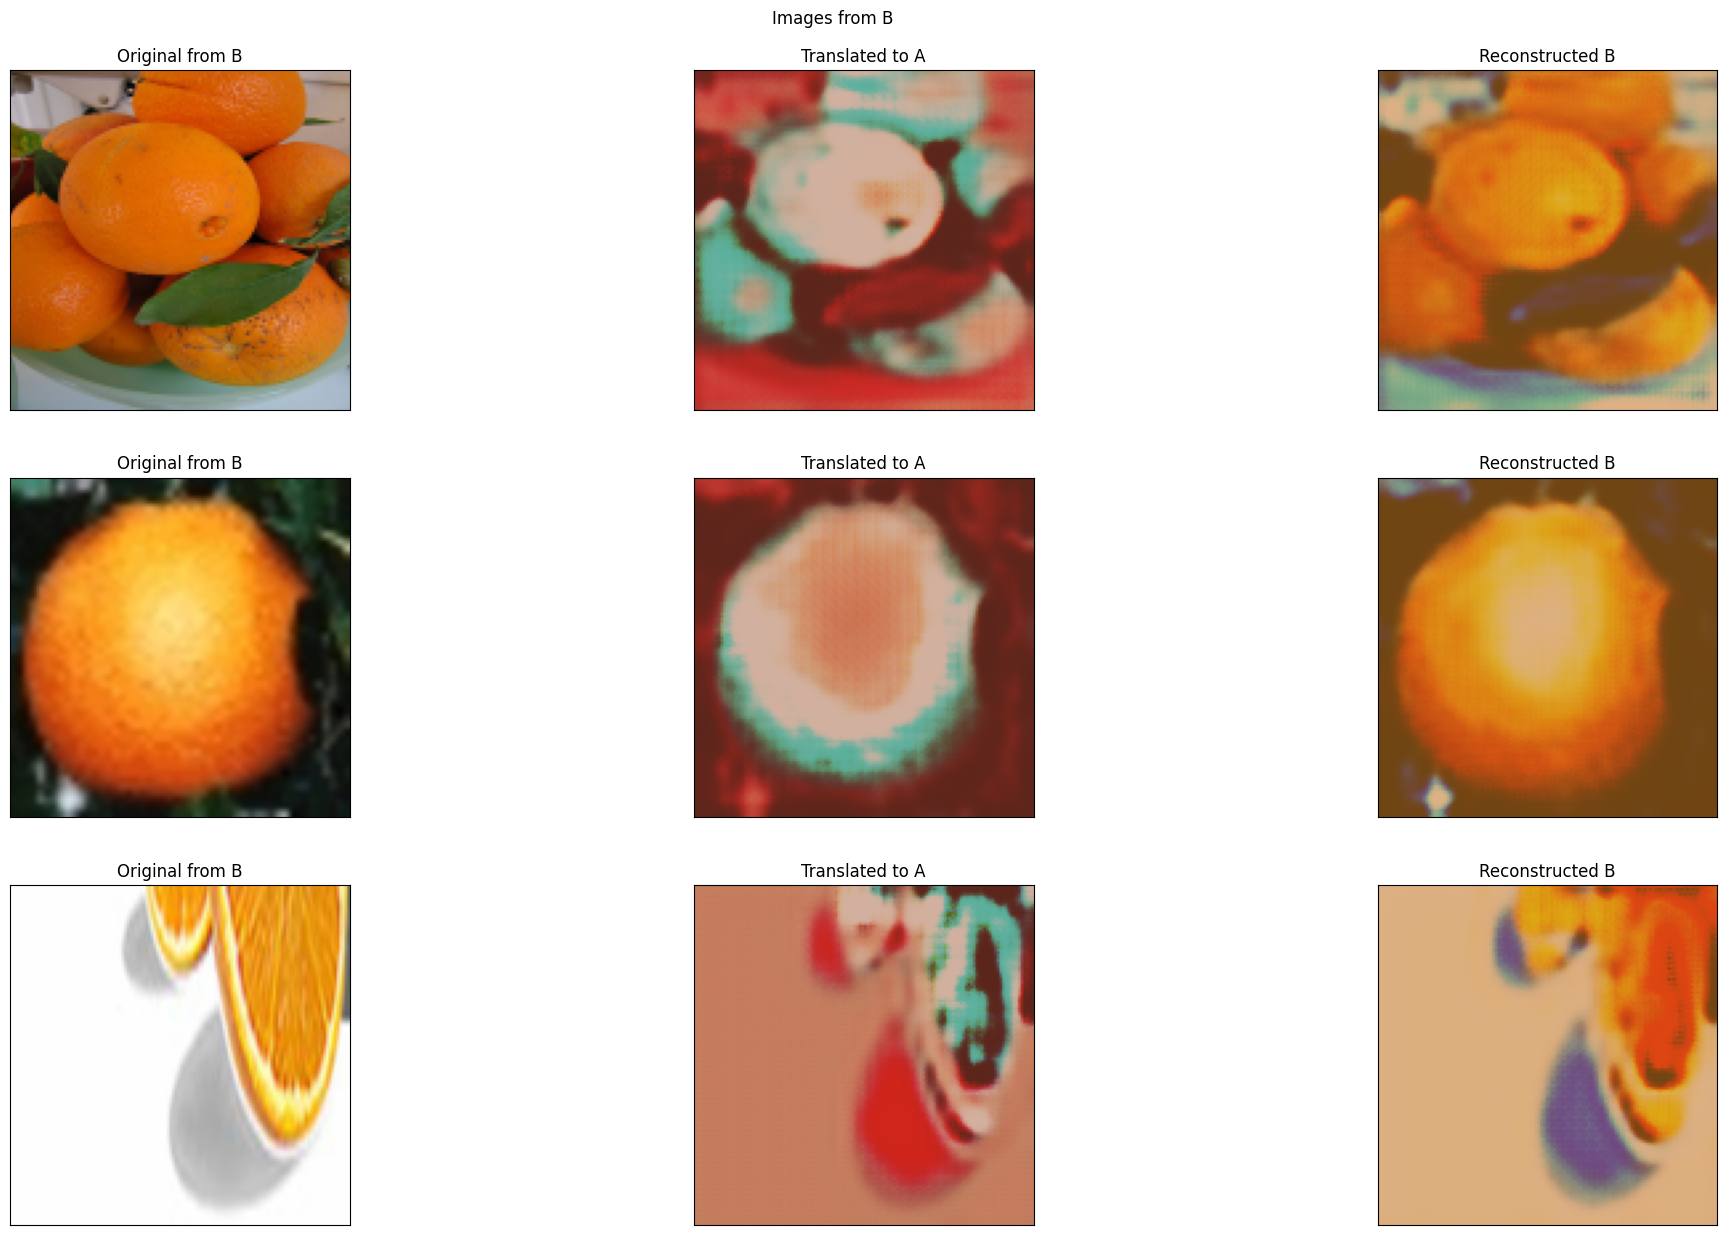

CPU times: user 7h 6min 10s, sys: 3min 18s, total: 7h 9min 29s
Wall time: 49min 28s


In [ ]:
%%time
model, optimizer_d, optimizer_g, plots = learning_loop(
    model = model,
    optimizer_g = optimizer_g,
    g_iters_per_epoch = 1,
    optimizer_d = optimizer_d,
    d_iters_per_epoch = 1,
    train_loader_a = dataloaders.train_a,
    train_loader_b = dataloaders.train_b,
    val_loader_a = dataloaders.test_a,
    val_loader_b = dataloaders.test_b,
    criterion_d = criterion_d,
    criterion_g = criterion_g,
    scheduler_g = scheduler_g,
    scheduler_d = scheduler_d,
    de_norm_a = de_normalize_a,
    de_norm_b = de_normalize_b,
    epochs = 40,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    chkp_folder = "./chkp",
    model_name = "cyclegan_apple",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
)

Исходя из результатов теста... Мы точно можем сказать что яблоки должны быть красные, а апельсины - орнажевые....

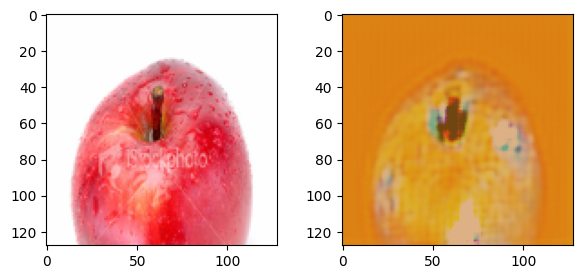

In [ ]:
img_a = ds.test_a[10].to(device).unsqueeze(0)

plt.subplots(1, 2, figsize=(7, 3))

plt.subplot(121)
plt.imshow(de_normalize_a(img_a[0]))

plt.subplot(122)
plt.imshow(de_normalize_b(model.G_AB(img_a)[0].cpu().detach()))

plt.show()

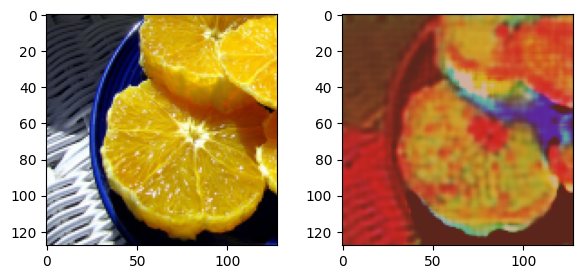

In [ ]:
img_b = ds.test_b[25].to(device).unsqueeze(0)
fake_a = model.G_BA(img_b)

plt.subplots(1, 2, figsize=(7, 3))

plt.subplot(121)
plt.imshow(de_normalize_b(img_b[0].cpu().detach()))

plt.subplot(122)
plt.imshow(de_normalize_a(fake_a[0].cpu().detach()))

plt.show()